Gebruikte bronnen en resources voor Flumph berekeningen:<br>
https://www.youtube.com/watch?v=ZENBQj2qQ2k<br>
https://www.youtube.com/watch?v=IYaOMor9qvE<br>
https://en.wikipedia.org/wiki/Markov_chain<br>
https://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html<br>

Uitleg is zowel verwerkt in markdowns als in comments in de code zelf. Alle code is uitgewerkt met functies en herbruikbaar voor allerlei maten matrices en vectors.

In [204]:
import numpy as np # only used for calculation state after 100 days using eigenbasis
from numpy import linalg # only used for calculation state after 100 days using eigenbasis
import matplotlib.pyplot as plt # for plotting graphs
from matplotlib import style
style.use('ggplot') # for styling plots with rasters
plt.rcParams['figure.figsize'] = [14,7] # set size of graphs

In [205]:
# Function to perform matrix multiplication
def dot_product(matrix1, matrix2):
    matrix1_rows = len(matrix1)
    matrix1_cols = len(matrix1[0])
    matrix2_rows = len(matrix2)
    matrix2_cols = len(matrix2[0])
    
    # if columns of first are not equal to rows of second, matrix multiplication is not possible
    if matrix1_cols != matrix2_rows: 
        raise Exception("Matrix multiplication is not possible because "+ str(matrix1_cols) +' != '+str(matrix2_rows))
        
    # create new empty productmatrix with size; amount of rows of first and columns of second
    productmatrix = [[0 for row in range(matrix2_cols)] for col in range(matrix1_rows)]
    
    # perform multiplication and create new matrix with product of 2 given matrices
    for i in range(matrix1_rows):
        for j in range(matrix2_cols):
            for h in range(matrix1_cols):
                productmatrix[i][j] += matrix1[i][h] * matrix2[h][j]
            
    return productmatrix

Nadat $((A\cdot A)\cdot A)\cdot A$ etc... een bepaald aantal keer is vermenigvuldigd met elkaar, wordt het verschil tussen huidige en vorige matrix steeds kleiner. Als het verschil erg klein wordt, is dat het punt waar de kansen vrijwel gelijk blijven over tijd. Het aantal keer dat $((A\cdot A)\cdot A)\cdot A$ uitgevoerd kan worden, is het aantal dagen dat het duurt voordat de zogenaamde 'long term probability' bereikt is. Ik had ook de functie np.allclose() van numpy kunnen gebruiken hiervoor.

In [206]:
# checks if matrices are (almost) identical
def is_not_equal(matrix1, matrix2, decimals): 
    total_columns = len(matrix1) * len(matrix1[0]) # number of times values should be the same
    count = 0 # counting identical values
    
    # checks if rounded values on given decimals are identical
    for i in range(len(matrix1)):
        for j in range(len(matrix1[0])):
            if round(matrix1[i][j], decimals) == round(matrix2[i][j], decimals):
                count+=1
                
    if count == total_columns: # if all values are counted as identical for 2 matrices, return False because they are equal
        return False
    else:
        return True

Onderstaande functie berekend het aantal dagen wanneer de lange termijn kansen niet meer veranderen. Door het laatste dot_product te vergelijken met de huidige matrix. Als de waardes in deze 2 matrices afgerond op 3 decimalen overeenkomen, is het aantal dagen van de lange termijn kans gevonden. Het vergelijken van de matrices wordt uitgevoerd door bovenstaande functie.

In [207]:
# calculates long term probability days by comparing last matrix with current matrix by using function is_not_equal
def long_term_probability_days(matrix):
    days = 0
    matrix_matrix = [[0 for row in range(len(matrix[0]))] for col in range(len(matrix))]
    
    # checks if matrices have same shape, and elements have close enough identical values
    while is_not_equal(matrix_matrix, matrix, 3): # 3 is number of decimals to round values in matrices for certain precision
        matrix_matrix = matrix
        matrix = dot_product(matrix_matrix, matrix_matrix)
        days += 1
        
    return days

In [208]:
# transposes a matrix, so that all values with same colomnindex, will be placed together in a row. So 3 columns become 3 rows.
def transpose_matrix(matrix):
    return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]

Als de lange termijn kans in dagen berekend is, kunnen we de kansen over tijd berekenen. Hiervoor gebruiken we de kansenmatrix, de startvector en het aantal dagen. Het aantal dagen bepaald hoevaak de berekening wordt uitgevoerd. De berekening is maakt gebruik van de functie dot_product voor vector matrix multiplicatie. 
Eerst wordt de eerste dot product berekend: $Vector\cdot Matrix$. Het resultaat van deze berekening is opnieuw een vector, en deze vector wordt weer met de kansenmatrix vermenigvuldigd. Dit proces $((Vector\cdot Matrix)\cdot Matrix)\cdot Matrix$ herhaalt zich tot het aantal dagen bereikt is. Dan weten we dat de productvector weinig tot niet zal veranderen.

In [209]:
def probability_over_time(matrix, vector, days):
    probabilities = []
    probabilities.append(vector[0]) # add first starting vector
    
    for d in range(days + 1): # +1 to show a little bit extra
        vector = dot_product(vector, matrix) # matrix dot product of vector with matrix
        probabilities.append(vector[0]) # add plot data to list
        
    return transpose_matrix(probabilities) # transpose matrix to convert columns into rows

Als laatst een functie om de data uit de getransponeerde matrix te plotten samen met bijbehorend label. Ik heb ervoor gekozen om de long_term_probability_days en probability_over_time berekening in deze functie te plaatsen. Ik had dit ook in de 'main' kunnen doen en deze variabelen door te geven aan de functie.

In [210]:
def plot_probabilities(matrix, vector, labels, title):
    days = long_term_probability_days(matrix) # get number of days after long term probability is reached
    probabilities = probability_over_time(matrix, vector, days) # get plot data in form of transposed matrix
    
    for index, vector in enumerate(probabilities):
        plt.plot(vector, label=labels[index]) # plot data with label
        
    plt.title(title + "\nLong term probability after " + str(days) + " days")
    plt.xlabel('Tijd in dagen ->')
    plt.ylabel('Kans x100 ->')
    plt.legend(loc='upper left')
    plt.show()

|  3 toestanden   | Morgen hongerig   | Morgen tevreden | Morgen opgejaagd |
|------|------|------|------|
|   Vandaag hongerig  | 80% | 10% | 10% |
|   Vandaag tevreden  | 40% | 50% | 10% |
|   Vandaag opgejaagd  | 60% | 20% | 20% |

$\begin{bmatrix}
{0.8} & {0.1} & {0.1}\\
{0.4} & {0.5} & {0.1}\\
{0.6} & {0.2} & {0.2}
\end{bmatrix}$ met start vector:
$\begin{bmatrix}
{0.1} & {0.7} & {0.2}
\end{bmatrix}$

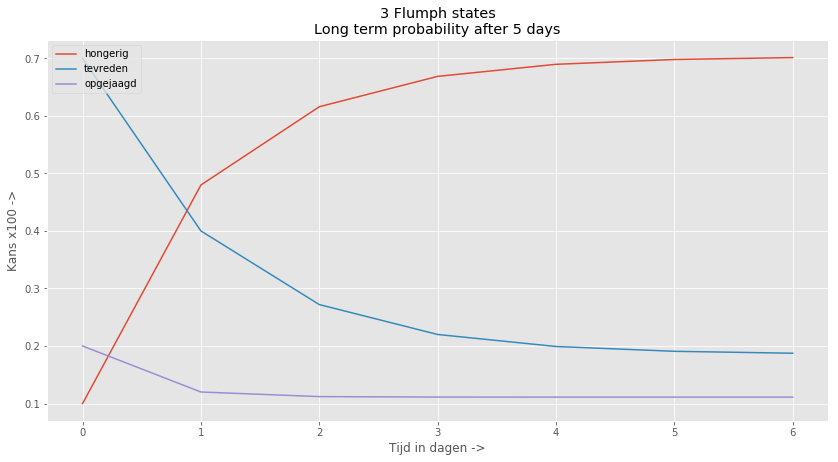

In [211]:
# 3 states:
matrix_three_states = [[0.8, 0.1, 0.1], # hongerig
                      [0.4, 0.5, 0.1], # tevreden
                      [0.6, 0.2, 0.2]] # opgejaagd
vector_three_states = [[0.1, 0.7, 0.2]] # start kans
labels_three_states = ["hongerig","tevreden","opgejaagd"]
plot_probabilities(matrix_three_states, vector_three_states, labels_three_states, "3 Flumph states")

|  4 toestanden   | Morgen hongerig   | Morgen tevreden | Morgen opgejaagd | Morgen dorst |
|------|------|------|------|------|
|   Vandaag hongerig  | 40% | 20% | 20% | 20% |
|   Vandaag tevreden  | 10% | 20% | 20% | 50% |
|   Vandaag opgejaagd  | 20% | 10% | 20% | 50% |
|   Vandaag dorst  | 40% | 20% | 10% | 30% |

$\begin{bmatrix}
{0.4} & {0.2} & {0.2} & {0.2}\\
{0.1} & {0.2} & {0.2} & {0.5}\\
{0.2} & {0.1} & {0.2} & {0.5}\\
{0.4} & {0.2} & {0.1} & {0.3}
\end{bmatrix}$ met start vector:
$\begin{bmatrix}
{0.1} & {0.4} & {0.3} & {0.2}
\end{bmatrix}$

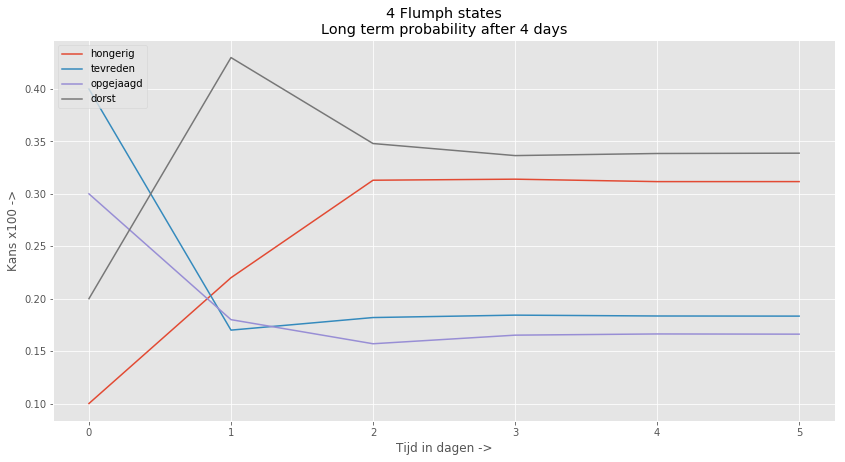

In [212]:
# 4 states:
matrix_four_states = [[0.4, 0.2, 0.2, 0.2], # hongerig
                     [0.1, 0.2, 0.2, 0.5], # tevreden
                     [0.2, 0.1, 0.2, 0.5], # opgejaagd
                     [0.4, 0.2, 0.1, 0.3]] # dorst
vector_four_states = [[0.1, 0.4, 0.3, 0.2]] # start kans
labels_four_states = ["hongerig","tevreden","opgejaagd","dorst"]
plot_probabilities(matrix_four_states, vector_four_states, labels_four_states, "4 Flumph states")

__Eigenbasis, Eigenvalues en Eigenvectors:__

Gebruikte bronnen en resources:<br>
https://www.youtube.com/watch?v=nnssRe5DewE&feature=youtu.be&t=401<br>
https://www.youtube.com/watch?v=PFDu9oVAE-g<br>
https://www.youtube.com/watch?v=SADvoCEekVg<br>
https://www.youtube.com/watch?v=Sf91gDhVZWU<br>
https://math.stackexchange.com/questions/1409350/what-is-an-eigenbasis-and-how-do-i-calculate-it-with-the-information-below<br>
https://intuitive-math.club/linear-algebra/eigenbasis<br.

__Berekening 100e toestand:__<br>

We willen de 100e toestand van matrix A
$\begin{bmatrix}
{0.8} & {0.1} & {0.1}\\
{0.4} & {0.5} & {0.1}\\
{0.6} & {0.2} & {0.2}
\end{bmatrix}$ met begintoestand vector $\vec{x}$
$\begin{bmatrix}
{0.1}\\
{0.7}\\
{0.2}
\end{bmatrix}$ berekenen met gebruik van eigenbasis

We zouden bovenstaande functie long_term_probability_days kunnen gebruiken om matrix A 100 keer met zichzelf te vermenigvuldigen, en vervolgens met $\vec{x}$ te vermenigvuldigen. Dit is echter aardig wat werk om uit te schrijven. Daarom gebruiken we eigenbasis, om op papier de $n^{e}$ toestand te kunnen berekenen. Hiervoor moeten een aantal stappen doorlopen worden. Ik zal per stap uitleggen wat er gedaan wordt, en waarom dit gedaan wordt. Om de $n^{e}$ toestand te berekenen, wordt de eigenbasis van een matrix berekend. De eigenbasis is een basis waar elke vector een eigenvector is, een matrix die hoort bij (eigen is van) de beginmatrix A. Om de eigenbasis van een matrix te berekenen moeten de eigenvalues en eigenvectors berekend worden. Een matrix heeft 0 of meerdere eigenvalues met eigenvectors.

Ik heb de functies zoveel mogelijk barebone gelaten. Geen controles op matrix groottes etc. Ik gebruik nu wel de numpy libraries omdat ik anders zelf een functie moet schrijven voor inversie en berekening eigenvalues en vectors.

__Stap 1 Eigenvalues en bijbehorende eigenvectors berekenen:__

Als allereerst worden de eigenvalues met bijbehorende eigenvectors berekend. Ik zal hier in stappen 'met de hand' de eigenvalues met eigenvectors berekenen.

Als eerst moet de waarde $\lambda$ (eigenvalue) gevonden worden zo dat $determinant(A - \lambda \cdot I) = 0$ ($I$ staat voor identiteitsmatrix.)

- $\lambda \cdot I$ = $\lambda \cdot$
$\begin{bmatrix}
{1} & {0} & {0}\\
{0} & {1} & {0}\\
{0} & {0} & {1}
\end{bmatrix}$ = 
$\begin{bmatrix}
{\lambda} & {0} & {0}\\
{0} & {\lambda} & {0}\\
{0} & {0} & {\lambda}
\end{bmatrix}$<br><br>


- $A - \lambda \cdot I$ = $\begin{bmatrix}
{0.8} & {0.1} & {0.1}\\
{0.4} & {0.5} & {0.1}\\
{0.6} & {0.2} & {0.2}
\end{bmatrix}$ - $\begin{bmatrix}
{\lambda} & {0} & {0}\\
{0} & {\lambda} & {0}\\
{0} & {0} & {\lambda}
\end{bmatrix}$ = $\begin{bmatrix}
{0.8 - \lambda} & {0.1} & {0.1}\\
{0.4} & {0.5 - \lambda} & {0.1}\\
{0.6} & {0.2} & {0.2 - \lambda}
\end{bmatrix}$


Nu moeten de eigenvalues berekend worden met $determinant(\begin{bmatrix}
{0.8 - \lambda} & {0.1} & {0.1}\\
{0.4} & {0.5 - \lambda} & {0.1}\\
{0.6} & {0.2} & {0.2 - \lambda}
\end{bmatrix}) = 0$

Bovenstaande matrix kan herschreven worden in de volgende vorm dmv de regel van Sarrus. (bron: https://nl.wikipedia.org/wiki/Determinant) De regel van sarus kan alleen gebruikt worden om de determinant van een 3x3 te berekenen. Omdat we al weten dat de determinant 0 moet zijn, kan die als =0 in de vergelijking gezet worden:

$((0.8 - \lambda)\cdot(0.5 - \lambda)\cdot(0.2 - \lambda))\,+$
$(0.1\cdot0.1\cdot0.6)\,+$
$(0.1\cdot0.4\cdot0.2)\,-$
$(0.1\cdot(0.5 - \lambda)\cdot0.6)\,-$
$(0.1\cdot0.4\cdot(0.2 - \lambda))\,-$
$(0.8\cdot0.1\cdot0.2)$
= 0

Door bovenstaande vergelijking uit te werken, komen er de volgende eigenvalues uit:
$\begin{bmatrix}
{1} & {0.4} & {0.1}
\end{bmatrix}$

We kunnen nu voor elke eigenvalue zijn bijbehorende eigenvector berekenen. Ik zal als voorbeeld de eerste eigenvalue gebruiken, 1:<br>
$\begin{bmatrix}
{0.8 - \lambda} & {0.1} & {0.1}\\
{0.4} & {0.5 - \lambda} & {0.1}\\
{0.6} & {0.2} & {0.2 - \lambda}
\end{bmatrix}$ = 
$\begin{bmatrix}
{0.8 - 1} & {0.1} & {0.1}\\
{0.4} & {0.5 - 1} & {0.1}\\
{0.6} & {0.2} & {0.2 - 1}
\end{bmatrix}$<br>
$\begin{bmatrix}
{-0.2} & {0.1} & {0.1}\\
{0.4} & {-0.5} & {0.1}\\
{0.6} & {0.2} & {-0.8}
\end{bmatrix} \cdot$
$\begin{bmatrix}
{x}\\
{y}\\
{z}
\end{bmatrix}$= 
$\begin{bmatrix}
{0}\\
{0}\\
{0}
\end{bmatrix}$

Bovenstaande vorm kan uitgewerkt worden met reduced row echelon form. En zal de volgende vector geven:
[-0.57735027 -0.27216553 -0.12309149]<br>

Nu hebben we de eigenvalues met bijbehorende eigenvectors berekend. We kunnen de values en vectors controleren door ze in te vullen in de $A \cdot \vec{x}$ gelijk is aan $\lambda \cdot \vec{x}$ vorm.

$1\cdot [-0.57735027 -0.27216553 -0.12309149]$ moet hetzelfde opleveren als$\begin{bmatrix}
{0.8} & {0.1} & {0.1}\\
{0.4} & {0.5} & {0.1}\\
{0.6} & {0.2} & {0.2}
\end{bmatrix}\cdot [-0.57735027 -0.27216553 -0.12309149]$ 

Hetzelfde geldt voor de 2 overige eigenvalues met eigenvectors.

__Bewijs dat $A \cdot \vec{x}$ gelijk is aan $\lambda \cdot \vec{x}$:__<br>

hier nog met een 2x2 matrix voorbeeld uitgewerkt dat $A \cdot \vec{x}$ gelijk is aan $\lambda \cdot \vec{x}$.

A is de gegeven matrix<br> 
$\vec{x}$ is de eigenvector<br>
$\lambda$ (lambda) is de eigenvalue (scalar)

$A \cdot \vec{x}$ is matrix vector multiplicatie<br>
$\lambda \cdot \vec{x}$ is scalar vector multiplicatie<br>

A:
$\begin{bmatrix}
{3} & {2}\\
{3} & {-2}
\end{bmatrix}$<br>
$\vec{x}$:
$\begin{bmatrix}
{2}\\
{1}
\end{bmatrix}$<br>
$\lambda$ = 4

$A \cdot \vec{x}$ (dot product) geeft 
$\begin{bmatrix}
{3} & {2}\\
{3} & {-2}
\end{bmatrix}$
$\cdot$
$\begin{bmatrix}
{2}\\
{1}
\end{bmatrix}$ = 
$\begin{bmatrix}
{3\cdot2} & {2\cdot1}\\
{3\cdot2} & {-2\cdot1}
\end{bmatrix}$ = 
$\begin{bmatrix}
{8}\\
{4}
\end{bmatrix}$

$\lambda \cdot \vec{x}$ geeft 
$4 \cdot
\begin{bmatrix}
{2}\\
{1}
\end{bmatrix}$ =
$\begin{bmatrix}
{4\cdot2}\\
{2\cdot1}
\end{bmatrix}$ =
$\begin{bmatrix}
{8}\\
{4}
\end{bmatrix}$

Als $\lambda$ inderdaad de eigenvalue is van matrix A en $\vec{x}$ hoort bij eigenvalue $\lambda$, dan zijn alle scalar products van $\vec{x}$ een eigenvector.

Dan zou ik het bovenstaande voorbeeld $\begin{bmatrix}
{10}\\
{5}
\end{bmatrix}$ of 
$\begin{bmatrix}
{20}\\
{10}
\end{bmatrix}$ als $\vec{x}$ bijvoorbeeld hetzelfde antwoord geven.
<br>

In [213]:
def eigenvalues_eigenvectors(matrix):
    return linalg.eig(matrix) # get eigenvalues with its eigenvector

__Stap 2 Diagonale matrix maken:__

Als de eigenvectors en eigenvalues berekend zijn kan de diagonale matrix opgesteld worden.  De diagonale matrix wordt opgesteld door de eigenvalues in een matrix te laden. De diagonale matrix er als volgt uit.
$\begin{bmatrix}
{1} & {0} & {0}\\
{0} & {0.4} & {0}\\
{0} & {0} & {0.1}
\end{bmatrix}$

In [214]:
def diagonalized_matrix(eigenvalues):
    return np.diag(eigenvalues) # fill eigenvalues diagonally in zeroed out matrix

__Stap 3 $n^{e}$ toestand matrix A berekenen:__

Voor de $n^{e}$ toestand van matrix A kan de volgende formule gebruikt worden:

$A^{n} = E \cdot D^{n} \cdot E^{-1}$

Waar $A^{n}$ het gewenste resultaat is $((A\cdot A)\cdot A)\cdot A$ etc....,<br>
$D^{n}$ de diagonale matrix n keer zichzelf is$D\cdot D\cdot D\cdot D\cdot$etc.... ,<br>
$E$ de eigenbasis is (matrix van eigenvectors),<br>
$E^{-1}$ de inversie van de eigenbasis is.

In [215]:
def nth_self_multiplication(diagonalized_matrix, eigenvectors, n):
    return eigenvectors @ linalg.matrix_power(diagonalized_matrix, n) @ eigenvectors.I # @ is same as np.dot

__Stap 4 $A^{n}\cdot\vec{x}$, het eindresultaat:__

Als de $A^{n}$ berekend is voor n = 100, moet het resultaat hiervan vermenigvuldigd worden (dot product) met start vector. Hier onder de werkelijke berekening met gebruik van bovenstaande functies. Alles wat ik tot nu toe gedaan heb, kan ook simpelweg met $print(np.dot(vector,linalg.matrix_power(matrix, 100)))$ berekend worden.

In [216]:
# start matrix
matrix = np.asmatrix([[0.8, 0.1, 0.1],
                  [0.4, 0.5, 0.1],
                  [0.6, 0.2, 0.2]]) # convert to numpy matrix to use numpy functions
# start vector
vector = np.asarray([[0.1, 0.7, 0.2]]) # convert to numpy vector to use numpy functions

# get eigenvalues and belonging eigenvectors matrix
eigenvalues, eigenvectors = eigenvalues_eigenvectors(matrix)
print("eigenvalues:\n",eigenvalues)
print("eigenvectors:\n",eigenvectors)

# get diagonalized matrix
diagonalized_matrix = diagonalized_matrix(eigenvalues)
print("Diagonalized matrix:\n", diagonalized_matrix)

# nth state
state = nth_self_multiplication(diagonalized_matrix, eigenvectors, 100) # after 100 days

# end result
print("Result:\n",vector @ state)

# same result using matrix_power
#print(np.dot(vector,linalg.matrix_power(matrix, 100)))

eigenvalues:
 [1.  0.4 0.1]
eigenvectors:
 [[-0.57735027 -0.27216553 -0.12309149]
 [-0.57735027  0.95257934 -0.12309149]
 [-0.57735027  0.13608276  0.98473193]]
Diagonalized matrix:
 [[1.  0.  0. ]
 [0.  0.4 0. ]
 [0.  0.  0.1]]
Result:
 [[0.7037037  0.18518519 0.11111111]]
